# Converting EtOAc Data

In Yates & McClellane, 1967 there are reported values for rate vs [H2SO4] in extreme acid mixtures for hydrolysis of esters. The author include EtOAc data in their plots but do not repport the values in Table 1 of that paper.

"Mechanisms of ester hydrolysis in aqueous sulfuric acids." Keith Yates and Robert A. McClelland, *J. Am. Chem. Soc.*, **1967**, *89*, 2686-2692. https://doi.org/10.1021/ja00987a033

We are pointed to work by Bell and also by Jaques

"The Kinetics of Ester Hydrolysis in Concentrated Aqueous Acids." R.P. Bell, A.L. Dowding, J.A. Noble, *J. Chem. Soc.* **1955**, 3106–3110. https://doi.org/10.1039/JR9550003106.

"The Hydrolysis of Ethyl Acetate in Concentrated Aqueous Sulphuric Acid." D. Jaques, *J. Chem. Soc.* **1965**, 3854–3904. https://doi.org/10.1039/JR9650003854.

Both report rates in sulphuric acid solution.  The data from Jaques is %H2SO4 but the data from Bell is in molar. Fortunately the H0 values are reported and we have built interpolator functions that use data sets of H0 vs %H2SO4 that can convert H0 to %H2SO4.

We can also attempt a more cumbersome conversion by converting the molarity to %H2SO4 using molar mass and tables of density vs conc. Will both of these methods agree?



## Setup

the code below will setup libraries and variables

In [1]:
##############################################################
### Set up libraries and global variables
##############################################################
 
import interpolators   ### import the following functions from local library
# interpolators.MakeInterpolationFunctionForH0inH2SO4byPercentWt()
# interpolators.MakeInterpolationFunctionForH2SO4byPercentWtinH0()
# interpolators.MakeInterpolationFunctionForH2OActivityinH2SO4byMoleFraction()
# interpolators.MakeInterpolationFunctionForH2OActivityinH2SO4byPercentWt()
# interpolators.MakeInterpolationFunctionForDensityofH2SO4byPercentWt()

import pandas as pd
pd.options.mode.chained_assignment = None    # no warning message and no exception is raised

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.optimize import curve_fit
from scipy.stats import linregress
from scipy.optimize import minimize
from scipy.optimize import minimize_scalar


from statsmodels.nonparametric.smoothers_lowess import lowess     # A function for interpolating a plot using the locally weighed scatterplot smoothing method. Returns smoothed x,y points
from scipy.interpolate import CubicSpline                         # A function for interpolating a plot using the cubic spline method. Returns an interpolation function.
from scipy.interpolate import interp1d                            # A function for interpolating a plot using the connect-the-dots method. Returns an interpolation function.
from scipy.interpolate import make_smoothing_spline               # A function for interpolating a plot using a Bspline algorithm. Returns an interpolation function.

from matplotlib.patches import PathPatch
from matplotlib.path import Path


#github_location = "https://raw.githubusercontent.com/blinkletter/4410PythonNotebooks/main/Class_30/data/"
github_location = "./data/"
github_H0_location = "https://raw.githubusercontent.com/blinkletter/4410PythonNotebooks/main/Class_08/data/H0_data/"
github_location_styles = "https://raw.githubusercontent.com/blinkletter/LFER-QSAR/main/styles/"
github_location_LFER_tables = "https://raw.githubusercontent.com/blinkletter/LFER-QSAR/main/data/"

molwtH2SO4 = 98.08
molwtH2O = 18.0
densityH2SO4 = 1.83
densityH2O = 1.000


## Comparing Data

Below we will plot the data for %H2SO4 reported by Lane using the values of Bell and my own converion of the molar concentrations reported by Bell to %H2SO4 



In [2]:
###################################################
### Import the data and perform calculations
###################################################

Data_File_Name = "Bell1955.csv"
Filename = github_location + Data_File_Name

df_Bell = pd.read_csv(Filename, 
                 delimiter = ",", 
                 skipinitialspace=True, 
#                 index_col="Substituent", 
                 comment = "#") 

print("Data from Bell 1955\n")

interpolator_H0 = interpolators.MakeInterpolationFunctionForH2SO4byPercentWtbyMolarConc()
Percent = interpolator_H0(df_Bell["[H2SO4] mole/L"])
df_Bell["%H2SO4"] = Percent

Data_File_Name = "Lane1968.csv"
Filename = github_location + Data_File_Name

df_Lane = pd.read_csv(Filename, 
                 delimiter = ",", 
                 skipinitialspace=True, 
#                 index_col="Substituent", 
                 comment = "#") 

percents_lane = df_Lane["%[H2SO4]"].to_numpy()
mask = [1,1,1,1,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0]
mask = np.array(mask, dtype=bool)
percents_lane = percents_lane[mask]

percents_bell = df_Bell["%H2SO4"].to_numpy()
mask = [1,0,1,1,1,1,1,1,1]
mask = np.array(mask, dtype=bool)
percents_bell = percents_bell[mask]


display(df_Bell)
display(percents_lane)
display(percents_bell)

Data from Bell 1955



,[H2SO4] mole/L,10^5 kobs,H0,%H2SO4
0,1.35,18.8,-0.31,11.992702
1,1.37,19.8,-0.33,12.157030
2,1.87,30.9,-0.62,16.202243
3,2.85,56.1,-1.15,23.714755
4,3.08,65.5,-1.25,25.390681
5,3.63,79.7,-1.50,29.263192
6,4.25,104.0,-1.80,33.408467
7,4.76,128.0,-2.05,36.654794
8,6.75,192.0,-3.03,48.110851


array([12.2 , 16.4 , 23.9 , 25.5 , 29.4 , 33.43, 36.67, 48.  ])

array([11.99270194, 16.20224302, 23.71475515, 25.39068094, 29.26319159,
       33.4084672 , 36.65479429, 48.11085146])

## Check Results

Here are the two sets of data plotted against each other and a plot of the differences. They should be identical and are very very close. the tables for properties of sulphuric acid mixtures have chamnges a little bit between 1968 and 2025.

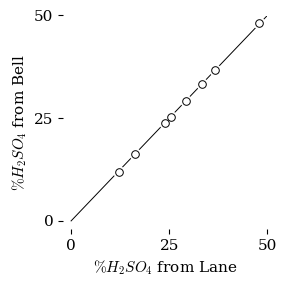

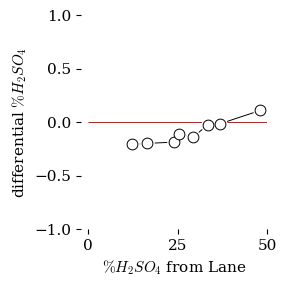

Mean differential is -0.095 +/- 0.105
Standard error of the mean is 0.040
95% confidence interval of the mean is 0.093


In [8]:
x = percents_lane
y = percents_bell
###################################################
### MAKE PLOT
###################################################

###################################################
### Create figure for plot
###################################################

style = "tufte.mplstyle"
#style = "S2_classic2.mplstyle"
style_name = github_location_styles + style
plt.style.use(style_name)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3,3))  
#ax2 = ax.twinx()

###################################################
### Set up labels
###################################################

x_label = r"$\%H_2SO_4$ from Lane" 
y_label = r"$\%H_2SO_4$ from Bell" 


###################################################
### RATE vs ACIDITY Plot
###################################################

# Set up axes for main plot
ax.set(ylabel=y_label, xlabel=x_label,
        xlim=[-2,50],
        ylim=[-2,50]
        )
# Data points for kobs vs Acidity

ax.scatter(x, y, 
          marker = "o", s = 30, 
          color = "white", edgecolors = "black", linewidths=0.7, 
          zorder = 2)
ax.scatter(x, y,           # White circle behind each data point 
          marker = "o", s = 60, 
          color = "white", 
          zorder = 1)
ax.set(xticks = [0,25,50],
       yticks = [0,25,50]
        )
# 1:1 line
x1 = np.linspace(0, 50, 100)
y1 = x1
ax.plot(x1, y1, 
        color = "black", linewidth=0.7, linestyle="-", 
        zorder = 0)     
plt.savefig("plots/plot3.pdf")
plt.show()

###################################################
###################################################
### Differential Plot
###################################################

diff = y - x
#df_Bell["Difference"] = diff
#display(df_Bell)


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3,3))  
#ax2 = ax.twinx()

###################################################
### Set up labels
###################################################

x_label = r"$\%H_2SO_4$ from Lane" 
y_label = r"differential $\%H_2SO_4$" 


###################################################
### Differential Plot
###################################################

# Set up axes for main plot
ax.set(ylabel=y_label, xlabel=x_label,
        xlim=[-2,50],
        ylim=[-1,1]
        )
# Data points for kobs vs Acidity

ax.scatter(x, diff, 
          marker = "o", s = 60, 
          color = "white", edgecolors = "black", linewidths=0.7, 
          zorder = 2
          )
ax.scatter(x, diff,           # White circle behind each data point 
          marker = "o", s = 90, 
          color = "white", 
          zorder = 1
          )
ax.plot(x, diff, 
        color = "black", linewidth=0.7, linestyle="solid", 
        zorder = 0 
        )
ax.set(xticks = [0,25,50],
#       yticks = [0,25,50]
        )
ax.hlines(0, xmin=0, xmax=50, colors="red", linestyles="solid", linewidth=0.7, zorder=0)
plt.savefig("plots/plot4.pdf")
plt.show()

mean = np.mean(diff)
print(f"Mean differential is {mean:0.3f} +/- {np.std(diff):0.3f}")

# stderr from standard deviation of the mean
stdev = stats.sem(diff)
print(f"Standard error of the mean is {stdev:0.3f}")
# 95% confidence interval of the mean
conf95 = stdev * stats.t.ppf((1 + 0.95) / 2., len(diff)-1)
print(f"95% confidence interval of the mean is {conf95:0.3f}")
#conf95range = stats.t.interval(0.95, len(diff)-1, loc=np.mean(diff), scale=stats.sem(diff))-mean




## Plotting Alkyl Ester Hydrolysis Rates

We have converted the concentrations reported by Bell from moles/L to %H2SO4 and found the values to be nearly identical to thos interpretted by Lane. Using Lanes data set and adding in the set at much higher concentrations of H2SO4 presented by Jaques we now have what was presumably used as the data set for Yates and McClelland.

We now have the data that we need to reproduce the plots in figure 1 of Yates McClelland. Let us see how we do.

The code below will plot the ester hydrolysis data into a combined plot. I have attaempted to use the same symbols as the authors.

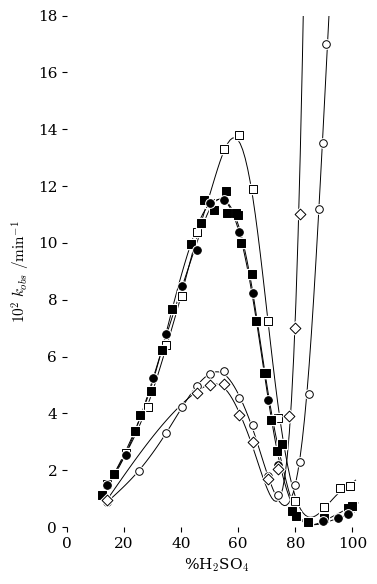

In [12]:
###################################################
### Import the data and perform calculations
###################################################

ester_list = ["MeOAc", "EtOAc", "nPrOAc", "iPrOAc", "secBuOAc", "BnOAc", "PhOAc", "p-ClPhOAc", "p-NO2PhOAc"]
ester_list = ["MeOAc", "EtOAc", "nPrOAc", "iPrOAc", "secBuOAc"]
#ester_list = ["MeOAc", "EtOAc", "nPrOAc"]
#ester_list = ["p-NO2PhOAc"]

symbol_dict = {
    "MeOAc": ["s", "white"], 
    "EtOAc": ["s", "black"],
    "nPrOAc": ["o", "black"],
    "iPrOAc": ["o", "white"],
    "secBuOAc": ["D", "white"],
    "BnOAc": ["D", "black"],
    "PhOAc": ["^", "white"],
    "p-ClPhOAc": ["+", "none"],
    "p-NO2PhOAc": ["x", "none"]
}  

Data_File_Name = "Yates_Table1.csv"
Filename = github_location + Data_File_Name

df = pd.read_csv(Filename, 
                 delimiter = ",", 
                 skipinitialspace=True, 
#                 index_col="Substituent", 
                 comment = "#") 


##########################################################
### Plot the value of -RSQ as the value of r is varied ###
##################################################

style_file = "tufte.mplstyle"
#style_file = "S2_classic2.mplstyle"
plt.style.use(github_location_styles + style_file)        



fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3.90,5.97))  
ax.margins(x=.07, y=.07, tight=True)      # add 7% empty space around outside of plot area   
ax.set(ylabel=r"$10^2\;k_{obs}\ /\text{min}^{-1}$", 
   xlabel=r"%H$_2$SO$_4$",
   ylim=[0.,18.0],                  
   xlim=[-0,105]
   )

for ester in ester_list:
    df1 = (df.loc[df['Ester'] == ester])   ### Select only the MeOAc data
    x = df1["%H2SO4"].to_numpy()
    y = df1["kobs"].to_numpy()

    sym = symbol_dict[ester][0]
    col = symbol_dict[ester][1]
    ax.scatter(x, y,           # White circle behind each data point 
              marker = sym, s = 45, 
              color = "white", 
              zorder = 2)
    ax.scatter(x, y, 
              marker = sym, s = 30, 
              color = col, edgecolors = "black", linewidths=0.7, 
              zorder = 2)

    # make a smooth interpolation line through the data
    x_smooth = np.linspace(min(x), max(x)+2, 100)
    spl = make_smoothing_spline(x, y, lam=20)
    y_smooth = spl(x_smooth)
    ax.plot(x_smooth, y_smooth, 
            color = "black", linewidth=0.7, linestyle="-", 
            zorder = 0)    

plt.savefig("plots/plot5_combo.pdf")   # use this to save the figure in PDF format
plt.show()

## Plot Individual Data Plots

The code below will plot the hydrolysis rate data into separate plots named according to the ester data set.

In [ ]:
###################################################
### Import the data and perform calculations
###################################################

ester_list = ["MeOAc", "EtOAc", "nPrOAc", "iPrOAc", "secBuOAc", "BnOAc", "PhOAc", "p-ClPhOAc", "p-NO2PhOAc"]
#ester_list = ["MeOAc", "EtOAc", "nPrOAc", "iPrOAc", "secBuOAc"]
#ester_list = ["MeOAc", "EtOAc", "nPrOAc"]
#ester_list = ["p-NO2PhOAc"]



Data_File_Name = "Yates_Table1.csv"
Filename = github_location + Data_File_Name

df = pd.read_csv(Filename, 
                 delimiter = ",", 
                 skipinitialspace=True, 
#                 index_col="Substituent", 
                 comment = "#") 


##########################################################
### Plot the value of -RSQ as the value of r is varied ###
##################################################

style_file = "tufte.mplstyle"
#style_file = "S2_classic2.mplstyle"
plt.style.use(github_location_styles + style_file)        




for ester in ester_list:
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3.90,5.97))  
    ax.margins(x=.07, y=.07, tight=True)      # add 7% empty space around outside of plot area   
    ax.set(ylabel=r"$\log{(k_{obs}\ /\text{min}^{-1})}$", 
       xlabel=r"\%H$_2$SO$_4$",
       ylim=[0.,18.0],                  
       xlim=[-0,105]
       )

    df1 = (df.loc[df['Ester'] == ester])   ### Select only the MeOAc data
    x = df1["%H2SO4"].to_numpy()
    y = df1["kobs"].to_numpy()
    ax.scatter(x, y, 
              marker = "o", s = 20, 
              color = "none", edgecolors = "red", linewidths=0.7, 
              zorder = 2)
    #ax.scatter(x, y,           # White circle behind each data point 
    #          marker = "o", s = 90, 
    #          color = "white", 
    #          zorder = 1)

    # make a smooth interpolation line through the data
    x_smooth = np.linspace(min(x), max(x)+2, 100)
    spl = make_smoothing_spline(x, y, lam=20)
    y_smooth = spl(x_smooth)
    ax.plot(x_smooth, y_smooth, 
            color = "black", linewidth=0.7, linestyle="-", 
            zorder = 0)    

    plt.savefig("plots/plot5-"+ester+".pdf")   # use this to save the figure in PDF format
    plt.show()

## Excess Acidity Analysis of Each ester Hydrolysis

The code below will use the excess acidity method to plot the dependance on the reaction wrt $a_{H_2O}$.

In [2]:
##############################################################
### DATAFRAME for ESTER HYDROLYSIS KINETIC DATA
##############################################################

##############################################################
### Import the data and perform calculations
##############################################################

Data_File_Name = "Yates_Table1.csv"

Filename = github_location + Data_File_Name

df = pd.read_csv(Filename, 
                 delimiter = ",", 
                 skipinitialspace=True, 
#                 index_col="Substituent", 
                 comment = "#") 
#display(df)

df1 = (df.loc[df['Ester'] == 'MeOAc'])   ### Select only the MeOAc data
#df1 = (df1.loc[0:11])   ### Select only the given lines

##############################################################
### Perform calculations
##############################################################

df1["kobs"] = df1["kobs"] * 1E-2 * 60    # convert from 10^-2 min^-1 to s^-1
#df1["kobs"] = df1["kobs"]

PercentH2SO4 = df1["%H2SO4"]
molesH2SO4 = PercentH2SO4 / molwtH2SO4
PercentH2O = 100 - PercentH2SO4
molesH2O = PercentH2O / molwtH2O
total_moles = molesH2SO4 + molesH2O
mole_fraction_H2SO4 = molesH2SO4 / total_moles

df1["X_H2SO4"] = mole_fraction_H2SO4

interpolatorH0 = interpolators.MakeInterpolationFunctionForH0inH2SO4byPercentWt()
df1["H0"] = interpolatorH0(PercentH2SO4)

m = 0.62
df1["HS"] = df1["H0"] * m

df1["log_k_obs"] = np.log10(df1["kobs"])

interpolator_aH2O = interpolators.MakeInterpolationFunctionForH2OActivityinH2SO4byPercentWt()
df1["aH2O"] = interpolator_aH2O(PercentH2SO4)

x,y = interpolators.DataForInterpolateH2OActivitybyPercentWtH2SO4()
df1["aH2O2"] = np.interp(PercentH2SO4, x, y)

print(x,y)
print(PercentH2SO4)
interpolator_density = interpolators.MakeInterpolationFunctionForDensityofH2SO4byPercentWt()
density = interpolator_density(PercentH2SO4)

volume = 1000
gramsH2O = volume * density * PercentH2O/100
molesH2O = gramsH2O / molwtH2O    # per liter

df1["Molar_H2O"] = molesH2O
X_H2O = 1-df1["X_H2SO4"]          # mole fraction H2O in H2SO4
gamma_H2O = df1["aH2O"] / (X_H2O)   # activity coefficient for H2O in H2SO4
df1["Molar_aH2O"] = gamma_H2O * df1["Molar_H2O"]

display(df1)

0      8.931954
1     16.399144
2     22.734578
3     28.177430
4     32.903918
5     37.046737
6     40.707713
7     43.966290
8     46.885357
9     49.515347
10    51.897175
11    54.064383
12    56.044729
13    57.861381
14    59.533830
15    61.078590
16    62.509747
17    63.839389
18    65.077946
19    66.234468
20    71.031286
21    74.634740
22    77.440895
23    79.688008
24    81.528004
25    83.062331
26    85.475250
27    87.286412
28    88.695967
29    89.824162
30    90.747594
31    95.149399
32    96.713121
33    97.514416
34    98.001599
35    98.990715
36    99.999999
Name: %H2SO4, dtype: float64 0     9.622000e-01
1     9.130000e-01
2     8.514000e-01
3     7.800000e-01
4     7.035000e-01
5     6.257000e-01
6     5.503000e-01
7     4.806000e-01
8     4.175000e-01
9     3.611000e-01
10    3.113000e-01
11    2.678000e-01
12    2.303000e-01
13    1.980000e-01
14    1.701000e-01
15    1.462000e-01
16    1.255000e-01
17    1.077000e-01
18    9.233000e-02
19    7.929000e-02

,Ester,%H2SO4,kobs,X_H2SO4,H0,HS,log_k_obs,aH2O,aH2O2,Molar_H2O,Molar_aH2O
0,MeOAc,14.10,0.9000,0.029243,-0.602729,-0.373692,-0.045757,9.296715e-01,0.928149,52.275506,50.063065
1,MeOAc,20.70,1.5660,0.045716,-1.037527,-0.643266,0.194792,8.733616e-01,0.871182,50.456009,46.177379
2,MeOAc,28.30,2.5320,0.067544,-1.511469,-0.937111,0.403464,7.780904e-01,0.778016,48.018411,40.069095
3,MeOAc,34.80,3.8460,0.089215,-1.999334,-1.239587,0.585009,6.687533e-01,0.667893,45.583389,33.470084
4,MeOAc,40.40,4.8840,0.110638,-2.418862,-1.499694,0.688776,5.568249e-01,0.556638,43.253973,27.081094
5,MeOAc,45.40,6.2400,0.132397,-2.793058,-1.731696,0.795185,4.495791e-01,0.449608,40.993898,21.242423
6,MeOAc,50.20,6.8400,0.156117,-3.233884,-2.005008,0.835056,3.465818e-01,0.346785,38.654042,15.875161
7,MeOAc,55.20,7.9800,0.184424,-3.781791,-2.344711,0.902003,2.461680e-01,0.246296,36.026757,10.874077
8,MeOAc,60.40,8.2800,0.218701,-4.396537,-2.725853,0.918030,1.564553e-01,0.156699,33.063932,6.621060
9,MeOAc,65.20,7.1400,0.255866,-5.004720,-3.102926,0.853698,9.112634e-02,0.090954,30.078638,3.683415
